In [11]:

data_path = r"C:\Users\visio\heart_failure_outputs\data\heart_failure_clinical_records_dataset.csv"
results_dir = r"C:\Users\visio\heart_failure_outputs\11-12-2025 results"

import os
os.makedirs(results_dir, exist_ok=True)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, RocCurveDisplay
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


df = pd.read_csv(data_path)
print(df.head())
print(df.shape)

-
target_col = "DEATH_EVENT"
X = df.drop(columns=[target_col])
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

In [13]:
def evaluate_on_test(model, X_train, y_train, X_test, y_test, model_name="Model"):
 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

 
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_proba)

    print(f"\n=== {model_name} – Test Metrics ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC-AUC  : {auc:.3f}")

    return acc, prec, rec, f1, auc


In [14]:
# Define models
rf  = RandomForestClassifier(random_state=42)
gb  = GradientBoostingClassifier(random_state=42)
lr  = LogisticRegression(max_iter=1000, random_state=42)
svm_clf = SVC(kernel="rbf", probability=True, random_state=42)

metrics_dict = {}

metrics_dict["Random Forest"]       = evaluate_on_test(rf,  X_train, y_train, X_test, y_test, "Random Forest")
metrics_dict["Gradient Boosting"]   = evaluate_on_test(gb,  X_train, y_train, X_test, y_test, "Gradient Boosting")
metrics_dict["Logistic Regression"] = evaluate_on_test(lr,  X_train, y_train, X_test, y_test, "Logistic Regression")
metrics_dict["SVM"]                 = evaluate_on_test(svm_clf, X_train, y_train, X_test, y_test, "SVM")


metrics_df = pd.DataFrame(metrics_dict, index=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]).T
print("\nMetrics Table (Test set):")
display(metrics_df)


metrics_df.to_csv(os.path.join(results_dir, "model_metrics_test.csv"), index=True)



=== Random Forest – Test Metrics ===
Accuracy : 0.833
Precision: 0.800
Recall   : 0.632
F1-score : 0.706
ROC-AUC  : 0.892

=== Gradient Boosting – Test Metrics ===
Accuracy : 0.833
Precision: 0.800
Recall   : 0.632
F1-score : 0.706
ROC-AUC  : 0.845

=== Logistic Regression – Test Metrics ===
Accuracy : 0.833
Precision: 0.846
Recall   : 0.579
F1-score : 0.688
ROC-AUC  : 0.860

=== SVM – Test Metrics ===
Accuracy : 0.683
Precision: 0.000
Recall   : 0.000
F1-score : 0.000
ROC-AUC  : 0.471

Metrics Table (Test set):


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Random Forest,0.833333,0.800000,0.631579,0.705882,0.891528
Gradient Boosting,0.833333,0.800000,0.631579,0.705882,0.844673
Logistic Regression,0.833333,0.846154,0.578947,0.687500,0.860077
SVM,0.683333,0.000000,0.000000,0.000000,0.471117


In [16]:
def crossval_metrics(model, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    X_np = X.values
    y_np = y.values

    for train_idx, val_idx in skf.split(X_np, y_np):
        X_tr, X_val = X_np[train_idx], X_np[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]


        m = model.__class__(**model.get_params())
        m.fit(X_tr, y_tr)
        y_pred = m.predict(X_val)

        if hasattr(m, "predict_proba"):
            y_proba = m.predict_proba(X_val)[:, 1]
        else:
            y_proba = m.decision_function(X_val)

        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec  = recall_score(y_val, y_pred)
        f1   = f1_score(y_val, y_pred)
        auc  = roc_auc_score(y_val, y_proba)

        metrics.append([acc, prec, rec, f1, auc])

    metrics = np.array(metrics)
    mean = metrics.mean(axis=0)
    std  = metrics.std(axis=0)

    metric_names = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
    print("Metric\t\tMean ± Std")
    for name, m, s in zip(metric_names, mean, std):
        print(f"{name:10s}: {m:.3f} ± {s:.3f}")

    return mean, std


In [18]:
def crossval_metrics(model, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    X_np = X.values
    y_np = y.values

    for train_idx, val_idx in skf.split(X_np, y_np):
        X_tr, X_val = X_np[train_idx], X_np[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]

        # fresh clone with same hyperparameters
        m = model.__class__(**model.get_params())
        m.fit(X_tr, y_tr)
        y_pred = m.predict(X_val)

        if hasattr(m, "predict_proba"):
            y_proba = m.predict_proba(X_val)[:, 1]
        else:
            y_proba = m.decision_function(X_val)

        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec  = recall_score(y_val, y_pred)
        f1   = f1_score(y_val, y_pred)
        auc  = roc_auc_score(y_val, y_proba)

        metrics.append([acc, prec, rec, f1, auc])

    metrics = np.array(metrics)
    mean = metrics.mean(axis=0)
    std  = metrics.std(axis=0)

    metric_names = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
    print("Metric\t\tMean ± Std")
    for name, m, s in zip(metric_names, mean, std):
        print(f"{name:10s}: {m:.3f} ± {s:.3f}")

    return mean, std


In [19]:
rf_cv_mean, rf_cv_std = crossval_metrics(rf, X, y, n_splits=10)
gb_cv_mean, gb_cv_std = crossval_metrics(gb, X, y, n_splits=10)
lr_cv_mean, lr_cv_std = crossval_metrics(lr, X, y, n_splits=10)
svm_cv_mean, svm_cv_std = crossval_metrics(svm_clf, X, y, n_splits=10)


Metric		Mean ± Std
Accuracy  : 0.843 ± 0.065
Precision : 0.789 ± 0.119
Recall    : 0.704 ± 0.162
F1-score  : 0.735 ± 0.119
ROC-AUC   : 0.897 ± 0.056
Metric		Mean ± Std
Accuracy  : 0.829 ± 0.067
Precision : 0.762 ± 0.130
Recall    : 0.696 ± 0.176
F1-score  : 0.715 ± 0.122
ROC-AUC   : 0.887 ± 0.068


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Metric		Mean ± Std
Accuracy  : 0.819 ± 0.072
Precision : 0.754 ± 0.124
Recall    : 0.653 ± 0.171
F1-score  : 0.692 ± 0.130
ROC-AUC   : 0.880 ± 0.057


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Metric		Mean ± Std
Accuracy  : 0.679 ± 0.015
Precision : 0.000 ± 0.000
Recall    : 0.000 ± 0.000
F1-score  : 0.000 ± 0.000
ROC-AUC   : 0.487 ± 0.128


In [20]:
from math import sqrt

def ci95(mean, std, n_folds=10):
    half_width = 1.96 * std / np.sqrt(n_folds)
    return mean - half_width, mean + half_width

acc_mean, acc_std = rf_cv_mean[0], rf_cv_std[0]
low, high = ci95(acc_mean, acc_std, n_folds=10)
print(f"RF Accuracy 95% CI: {low:.3f} – {high:.3f}")


RF Accuracy 95% CI: 0.803 – 0.883


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 700x600 with 0 Axes>

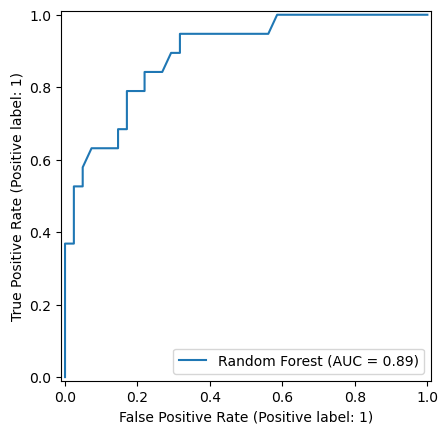

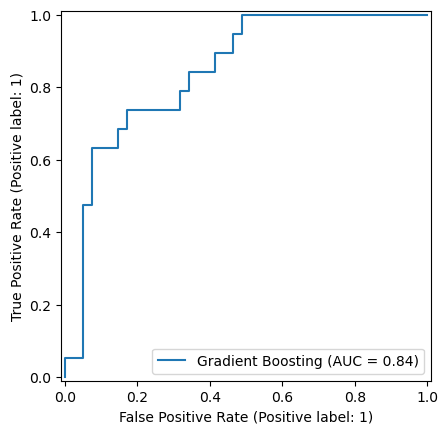

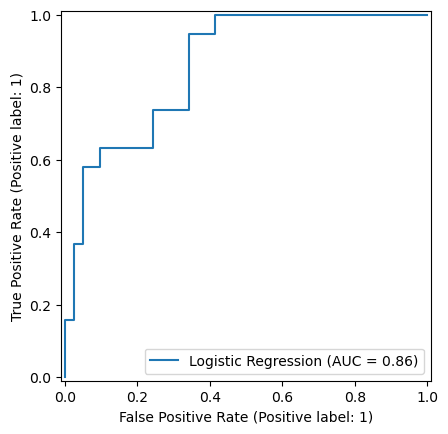

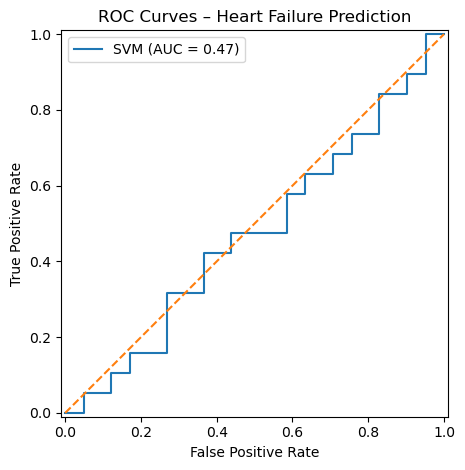

ROC figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\roc_curves_models.png


In [21]:
plt.figure(figsize=(7, 6))

for model, name in [
    (rf, "Random Forest"),
    (gb, "Gradient Boosting"),
    (lr, "Logistic Regression"),
    (svm_clf, "SVM"),
]:
    model.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)

plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Heart Failure Prediction")
plt.legend()
plt.tight_layout()

roc_path = os.path.join(results_dir, "roc_curves_models.png")
plt.savefig(roc_path, dpi=300)
plt.show()
print("ROC figure saved at:", roc_path)


In [22]:
from sklearn.utils.class_weight import compute_class_weight

scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn  = scaler.transform(X_test)


classes = np.unique(y_train)
class_weights_values = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights_values))
print("Class weights:", class_weights)


Class weights: {np.int64(0): np.float64(0.7376543209876543), np.int64(1): np.float64(1.551948051948052)}


In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_dim = X_train_nn.shape[1]

def build_fwdnn():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model_fwdnn = build_fwdnn()
model_fwdnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,681 (14.38 KB)

 Non-trainable params: 224 (896.00 B)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

checkpoint_path = os.path.join(results_dir, "best_fwdnn.h5")

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [26]:
history = model_fwdnn.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights,   
    verbose=1
)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4501 - auc: 0.4555 - loss: 0.9690
Epoch 1: val_auc improved from None to 0.53838, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.4660 - auc: 0.4795 - loss: 0.9449 - val_accuracy: 0.5833 - val_auc: 0.5384 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 2/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4062 - auc: 0.4712 - loss: 0.8565
Epoch 2: val_auc improved from 0.53838 to 0.56364, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4921 - auc: 0.4990 - loss: 0.8979 - val_accuracy: 0.5833 - val_auc: 0.5636 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 3/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5625 - auc: 0.6094 - loss: 0.6684
Epoch 3: val_auc improved from 0.56364 to 0.59192, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5393 - auc: 0.5452 - loss: 0.8398 - val_accuracy: 0.5833 - val_auc: 0.5919 - val_loss: 0.6778 - learning_rate: 0.0010
Epoch 4/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - accuracy: 0.5312 - auc: 0.6273 - loss: 0.7042
Epoch 4: val_auc improved from 0.59192 to 0.63838, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5602 - auc: 0.5995 - loss: 0.7363 - val_accuracy: 0.6042 - val_auc: 0.6384 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 5/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6250 - auc: 0.7292 - loss: 0.6972
Epoch 5: val_auc improved from 0.63838 to 0.69091, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6545 - auc: 0.7473 - loss: 0.6260 - val_accuracy: 0.6667 - val_auc: 0.6909 - val_loss: 0.6621 - learning_rate: 0.0010
Epoch 6/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2812 - auc: 0.3593 - loss: 0.9705
Epoch 6: val_auc improved from 0.69091 to 0.72323, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5602 - auc: 0.5816 - loss: 0.7426 - val_accuracy: 0.6667 - val_auc: 0.7232 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 7/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6875 - auc: 0.7879 - loss: 0.5858
Epoch 7: val_auc improved from 0.72323 to 0.74040, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6440 - auc: 0.7246 - loss: 0.6267 - val_accuracy: 0.6458 - val_auc: 0.7404 - val_loss: 0.6438 - learning_rate: 0.0010
Epoch 8/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6250 - auc: 0.6771 - loss: 0.6747
Epoch 8: val_auc improved from 0.74040 to 0.75051, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5812 - auc: 0.5995 - loss: 0.7344 - val_accuracy: 0.6875 - val_auc: 0.7505 - val_loss: 0.6373 - learning_rate: 0.0010
Epoch 9/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7188 - auc: 0.8542 - loss: 0.4799
Epoch 9: val_auc improved from 0.75051 to 0.75758, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6649 - auc: 0.7614 - loss: 0.5974 - val_accuracy: 0.6875 - val_auc: 0.7576 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 10/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5625 - auc: 0.6068 - loss: 0.7344
Epoch 10: val_auc improved from 0.75758 to 0.76768, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6911 - auc: 0.7617 - loss: 0.5895 - val_accuracy: 0.6875 - val_auc: 0.7677 - val_loss: 0.6269 - learning_rate: 0.0010
Epoch 11/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6875 - auc: 0.8486 - loss: 0.5380
Epoch 11: val_auc improved from 0.76768 to 0.77273, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7120 - auc: 0.8029 - loss: 0.5586 - val_accuracy: 0.7083 - val_auc: 0.7727 - val_loss: 0.6209 - learning_rate: 0.0010
Epoch 12/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6875 - auc: 0.8092 - loss: 0.5908
Epoch 12: val_auc did not improve from 0.77273
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7225 - auc: 0.8085 - loss: 0.5479 - val_accuracy: 0.7292 - val_auc: 0.7697 - val_loss: 0.6141 - learning_rate: 0.0010
Epoch 13/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7188 - auc: 0.8333 - loss: 0.4927
Epoch 13: val_auc did not improve from 0.77273
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7068 - auc: 0.8188 - loss: 0.5275 - val_accuracy: 0.7083 - val_auc: 0.7707 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 14/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7188 - auc: 0.8506 - loss: 0.4774
Epoch 14: val_auc did not improve from 0.77273
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7225 - auc: 0.8268 - loss: 0.5183 - val_accuracy: 0.7500 - val_auc: 0.7737 - val_loss: 0.5790 - learning_rate: 0.0010
Epoch 21/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6562 - auc: 0.8021 - loss: 0.5201
Epoch 21: val_auc did not improve from 0.77374
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7330 - auc: 0.8613 - loss: 0.4589 - val_accuracy: 0.7500 - val_auc: 0.7727 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 22/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6875 - auc: 0.8225 - loss: 0.5123
Epoch 22: val_auc improved from 0.77374 to 0.77374, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7487 - auc: 0.8582 - loss: 0.4660 - val_accuracy: 0.7500 - val_auc: 0.7737 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 23/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7188 - auc: 0.8343 - loss: 0.5096
Epoch 23: val_auc improved from 0.77374 to 0.78081, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7592 - auc: 0.8445 - loss: 0.5066 - val_accuracy: 0.7292 - val_auc: 0.7808 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 24/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - accuracy: 0.6875 - auc: 0.8333 - loss: 0.5094
Epoch 24: val_auc improved from 0.78081 to 0.78384, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7801 - auc: 0.8368 - loss: 0.4947 - val_accuracy: 0.7292 - val_auc: 0.7838 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 25/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.9375 - auc: 0.9903 - loss: 0.3105
Epoch 25: val_auc improved from 0.78384 to 0.79293, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8115 - auc: 0.8703 - loss: 0.4534 - val_accuracy: 0.7292 - val_auc: 0.7929 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 26/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9062 - auc: 0.9802 - loss: 0.3486
Epoch 26: val_auc improved from 0.79293 to 0.80000, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7801 - auc: 0.8927 - loss: 0.4266 - val_accuracy: 0.7292 - val_auc: 0.8000 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 27/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7812 - auc: 0.9136 - loss: 0.3763
Epoch 27: val_auc did not improve from 0.80000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7696 - auc: 0.8789 - loss: 0.4439 - val_accuracy: 0.7292 - val_auc: 0.7980 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 28/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9062 - auc: 0.9091 - loss: 0.3796
Epoch 28: val_auc did not improve from 0.80000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8429 - auc: 0.9089 - loss: 0.4008 - val_accuracy: 0.7292 - val_auc: 0.7980 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 29/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7500 - auc: 0.9231 - loss: 0.3595
Epoch 29: val_auc did not improve from 0.80000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8325 - auc: 0.9032 - loss: 0.3998 - val_accuracy: 0.7500 - val_auc: 0.8010 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 32/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7812 - auc: 0.8354 - loss: 0.4900
Epoch 32: val_auc improved from 0.80101 to 0.80808, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8010 - auc: 0.9070 - loss: 0.3869 - val_accuracy: 0.7500 - val_auc: 0.8081 - val_loss: 0.5488 - learning_rate: 0.0010
Epoch 33/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9062 - auc: 0.9917 - loss: 0.2198
Epoch 33: val_auc improved from 0.80808 to 0.81212, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8168 - auc: 0.9056 - loss: 0.3894 - val_accuracy: 0.7500 - val_auc: 0.8121 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 34/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8438 - auc: 0.8971 - loss: 0.4577
Epoch 34: val_auc improved from 0.81212 to 0.81414, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8010 - auc: 0.8772 - loss: 0.4456 - val_accuracy: 0.7500 - val_auc: 0.8141 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 35/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8750 - auc: 0.9208 - loss: 0.3723
Epoch 35: val_auc improved from 0.81414 to 0.81919, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8377 - auc: 0.9219 - loss: 0.3626 - val_accuracy: 0.7500 - val_auc: 0.8192 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 36/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8750 - auc: 0.9159 - loss: 0.3539
Epoch 36: val_auc improved from 0.81919 to 0.82222, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8377 - auc: 0.9055 - loss: 0.3922 - val_accuracy: 0.7500 - val_auc: 0.8222 - val_loss: 0.5370 - learning_rate: 0.0010
Epoch 37/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8125 - auc: 0.8831 - loss: 0.4397
Epoch 37: val_auc improved from 0.82222 to 0.82424, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7853 - auc: 0.9010 - loss: 0.3953 - val_accuracy: 0.7500 - val_auc: 0.8242 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 38/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7812 - auc: 0.8500 - loss: 0.4924
Epoch 38: val_auc improved from 0.82424 to 0.82525, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8429 - auc: 0.9074 - loss: 0.4029 - val_accuracy: 0.7500 - val_auc: 0.8253 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 39/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.8125 - auc: 0.8955 - loss: 0.4258
Epoch 39: val_auc improved from 0.82525 to 0.82828, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8429 - auc: 0.9224 - loss: 0.3654 - val_accuracy: 0.7500 - val_auc: 0.8283 - val_loss: 0.5352 - learning_rate: 0.0010
Epoch 40/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7812 - auc: 0.9429 - loss: 0.3727
Epoch 40: val_auc did not improve from 0.82828
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8429 - auc: 0.9104 - loss: 0.3878 - val_accuracy: 0.7500 - val_auc: 0.8283 - val_loss: 0.5343 - learning_rate: 0.0010
Epoch 41/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9375 - auc: 0.9917 - loss: 0.2286
Epoch 41: val_auc did not improve from 0.82828
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8115 - auc: 0.9169 - loss: 0.3748 - val_accuracy: 0.7500 - val_auc: 0.8283 - val_loss: 0.5334 - learning_rate: 0.0010
Epoch 42/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7812 - auc: 0.9486 - loss: 0.3468
Epoch 42: val_auc improved from 0.82828 to 0.83232, saving model to C:\Users\visio\heart_failure_

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8220 - auc: 0.9169 - loss: 0.3711 - val_accuracy: 0.7500 - val_auc: 0.8323 - val_loss: 0.5331 - learning_rate: 0.0010
Epoch 43/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8125 - auc: 0.9227 - loss: 0.3578
Epoch 43: val_auc improved from 0.83232 to 0.83535, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8115 - auc: 0.9079 - loss: 0.3852 - val_accuracy: 0.7500 - val_auc: 0.8354 - val_loss: 0.5324 - learning_rate: 0.0010
Epoch 44/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 0.7188 - auc: 0.8401 - loss: 0.5203
Epoch 44: val_auc improved from 0.83535 to 0.84040, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8272 - auc: 0.9085 - loss: 0.3905 - val_accuracy: 0.7500 - val_auc: 0.8404 - val_loss: 0.5292 - learning_rate: 0.0010
Epoch 45/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7188 - auc: 0.8629 - loss: 0.4589
Epoch 45: val_auc improved from 0.84040 to 0.84444, saving model to C:\Users\visio\heart_failure_outputs\11-12-2025 results\best_fwdnn.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8272 - auc: 0.9096 - loss: 0.3852 - val_accuracy: 0.7500 - val_auc: 0.8444 - val_loss: 0.5262 - learning_rate: 0.0010
Epoch 46/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8438 - auc: 0.9886 - loss: 0.2481
Epoch 46: val_auc did not improve from 0.84444
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8534 - auc: 0.9245 - loss: 0.3579 - val_accuracy: 0.7500 - val_auc: 0.8424 - val_loss: 0.5262 - learning_rate: 0.0010
Epoch 47/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8125 - auc: 0.9487 - loss: 0.3855
Epoch 47: val_auc did not improve from 0.84444
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8377 - auc: 0.9123 - loss: 0.3830 - val_accuracy: 0.7500 - val_auc: 0.8414 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 48/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9062 - auc: 1.0000 - loss: 0.2347
Epoch 48: val_auc did not improve from 0.84444
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.

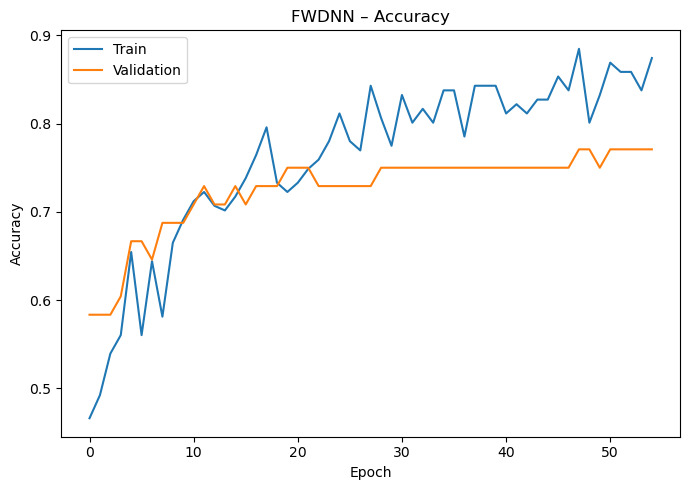

FWDNN Accuracy figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\fwdnn_accuracy.png


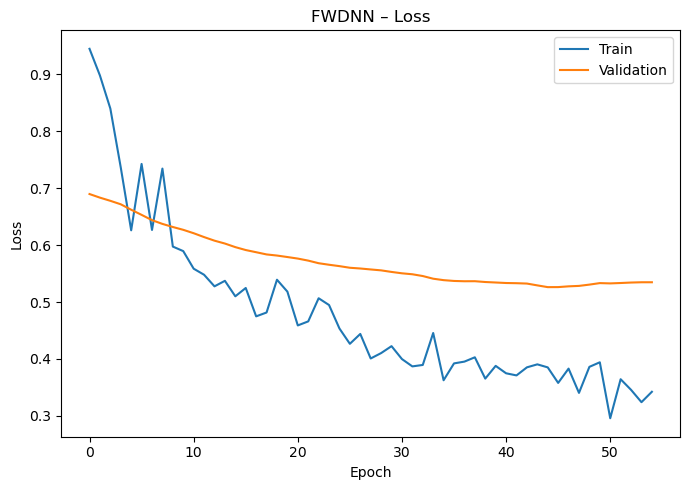

FWDNN Loss figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\fwdnn_loss.png


In [28]:

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FWDNN – Accuracy')
plt.legend()
plt.tight_layout()
acc_path = os.path.join(results_dir, "fwdnn_accuracy.png")
plt.savefig(acc_path, dpi=300)
plt.show()
print("FWDNN Accuracy figure saved at:", acc_path)


plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FWDNN – Loss')
plt.legend()
plt.tight_layout()
loss_path = os.path.join(results_dir, "fwdnn_loss.png")
plt.savefig(loss_path, dpi=300)
plt.show()
print("FWDNN Loss figure saved at:", loss_path)


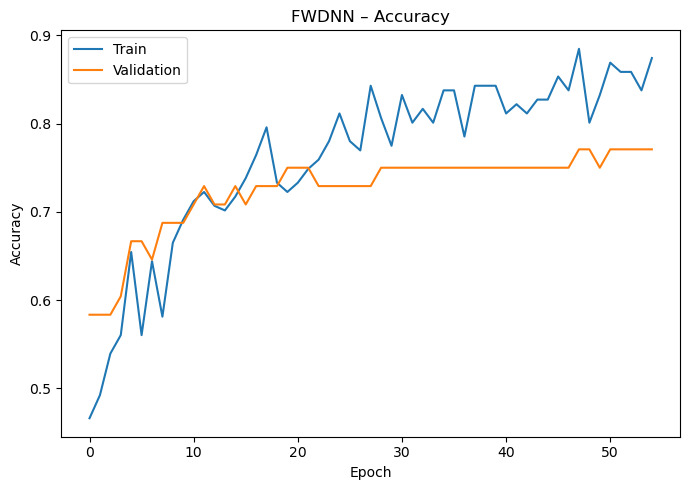

FWDNN Accuracy figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\fwdnn_accuracy.png


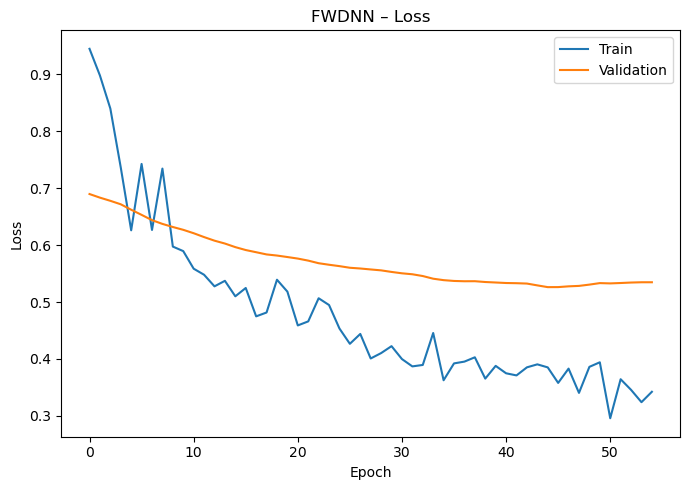

FWDNN Loss figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\fwdnn_loss.png


In [29]:

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FWDNN – Accuracy')
plt.legend()
plt.tight_layout()
acc_path = os.path.join(results_dir, "fwdnn_accuracy.png")
plt.savefig(acc_path, dpi=300)
plt.show()
print("FWDNN Accuracy figure saved at:", acc_path)


plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FWDNN – Loss')
plt.legend()
plt.tight_layout()
loss_path = os.path.join(results_dir, "fwdnn_loss.png")
plt.savefig(loss_path, dpi=300)
plt.show()
print("FWDNN Loss figure saved at:", loss_path)


In [30]:
y_proba_nn = model_fwdnn.predict(X_test_nn).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

acc_nn  = accuracy_score(y_test, y_pred_nn)
prec_nn = precision_score(y_test, y_pred_nn)
rec_nn  = recall_score(y_test, y_pred_nn)
f1_nn   = f1_score(y_test, y_pred_nn)
auc_nn  = roc_auc_score(y_test, y_proba_nn)

print("\n=== FWDNN – Test Metrics ===")
print(f"Accuracy : {acc_nn:.3f}")
print(f"Precision: {prec_nn:.3f}")
print(f"Recall   : {rec_nn:.3f}")
print(f"F1-score : {f1_nn:.3f}")
print(f"ROC-AUC  : {auc_nn:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step

=== FWDNN – Test Metrics ===
Accuracy : 0.750
Precision: 0.611
Recall   : 0.579
F1-score : 0.595
ROC-AUC  : 0.875


In [31]:

!pip install shap


Access is denied.


In [32]:
import shap


In [33]:
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [34]:
explainer = shap.TreeExplainer(rf)

if X_train.shape[0] > 300:
    X_sample = X_train.sample(300, random_state=42)
else:
    X_sample = X_train.copy()

shap_values = explainer.shap_values(X_sample)
len(shap_values)  # for binary classification usually 2 (class 0, class 1)


239

In [35]:
plt.figure()
shap.summary_plot(
    shap_values[1], X_sample,
    plot_type="bar",
    max_display=10,
    show=False
)
plt.title("Top 10 Features – SHAP Importance (Random Forest)")
plt.tight_layout()

shap_bar_path = os.path.join(results_dir, "shap_bar_rf_top10.png")
plt.savefig(shap_bar_path, dpi=300)
plt.show()
print("SHAP bar figure saved at:", shap_bar_path)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [42]:
shap.summary_plot(
    shap_values[1], X_sample,
    max_display=10
)

plt.tight_layout()
shap_swarm_path = os.path.join(results_dir, "shap_beeswarm_rf_top10.png")
plt.savefig(shap_swarm_path, dpi=300)
plt.show()
print("SHAP beeswarm figure saved at:", shap_swarm_path)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [37]:
mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)
feature_importance = pd.DataFrame({
    "Feature": X_sample.columns,
    "Mean|SHAP|": mean_abs_shap
}).sort_values("Mean|SHAP|", ascending=False)

print("Top 10 important features by SHAP:")
display(feature_importance.head(10))

shap_table_path = os.path.join(results_dir, "shap_feature_importance_rf.csv")
feature_importance.to_csv(shap_table_path, index=False)
print("SHAP importance table saved at:", shap_table_path)


ValueError: All arrays must be of the same length

In [43]:


import shap


rf.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf)


if isinstance(X_train, pd.DataFrame):
    X_sample = X_train.sample(min(200, len(X_train)), random_state=42)
else:

    X_sample = X_train

shap_values = explainer.shap_values(X_sample)


In [44]:


shap.summary_plot(
    shap_values[1], X_sample,
    plot_type="bar",
    max_display=10,
    show=False
)
plt.title("Top 10 Features – SHAP Importance (Random Forest)")
plt.tight_layout()
plt.show()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [45]:


shap.summary_plot(
    shap_values[1], X_sample,
    max_display=10
)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [48]:


mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)

if isinstance(X_sample, pd.DataFrame):
    feature_names = X_sample.columns
else:
    feature_names = [f"f{i}" for i in range(X_sample.shape[1])]

feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "MeanAbsSHAP": mean_abs_shap
}).sort_values("MeanAbsSHAP", ascending=False)

feature_importance.head(10)


ValueError: All arrays must be of the same length

In [49]:

rf.fit(X_train, y_train)


if X_train.shape[0] > 300:
    X_sample = X_train.sample(300, random_state=42)
else:
    X_sample = X_train.copy()

print("X_sample shape:", X_sample.shape)


X_sample shape: (239, 12)


In [50]:


import shap
shap.explainers._tree.Tree = shap.TreeExplainer  # sometimes needed in older versions

explainer = shap.TreeExplainer(rf)
shap_values_raw = explainer.shap_values(X_sample)

import numpy as np


if isinstance(shap_values_raw, list):
    # For binary classification usually [class0, class1]
    if len(shap_values_raw) == 2:
        sv = np.array(shap_values_raw[1])   # positive class
    else:
        sv = np.array(shap_values_raw[0])
else:
    sv = np.array(shap_values_raw)

print("Raw shap_values shape:", sv.shape)


if sv.ndim == 2 and sv.shape[1] == X_sample.shape[1] + 1:
    sv = sv[:, :-1]


assert sv.shape[0] == X_sample.shape[0], "Rows mismatch between SHAP and X_sample"
assert sv.shape[1] == X_sample.shape[1], (
    f"Columns mismatch: sv={sv.shape[1]}, X={X_sample.shape[1]}"
)

shap_values_fixed = sv
print("Fixed shap_values shape:", shap_values_fixed.shape)


Raw shap_values shape: (239, 12, 2)
Fixed shap_values shape: (239, 12, 2)


<Figure size 640x480 with 0 Axes>

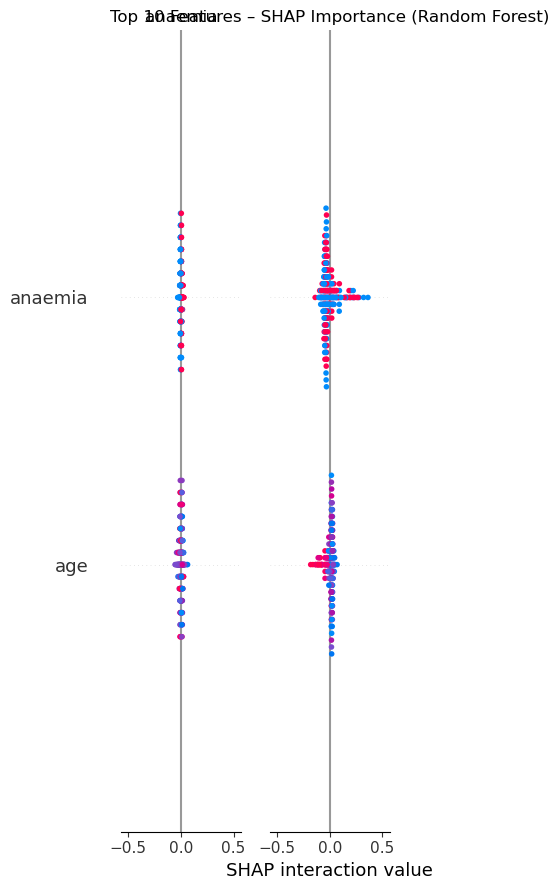

SHAP bar figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\shap_bar_rf_top10.png


In [57]:


plt.figure()
shap.summary_plot(
    shap_values_fixed,
    X_sample,
    plot_type="bar",
    max_display=10,
    show=False   
)
plt.title("Top 10 Features – SHAP Importance (Random Forest)")
plt.tight_layout()

shap_bar_path = os.path.join(results_dir, "shap_bar_rf_top10.png")
plt.savefig(shap_bar_path, dpi=300)
plt.show()

print("SHAP bar figure saved at:", shap_bar_path)


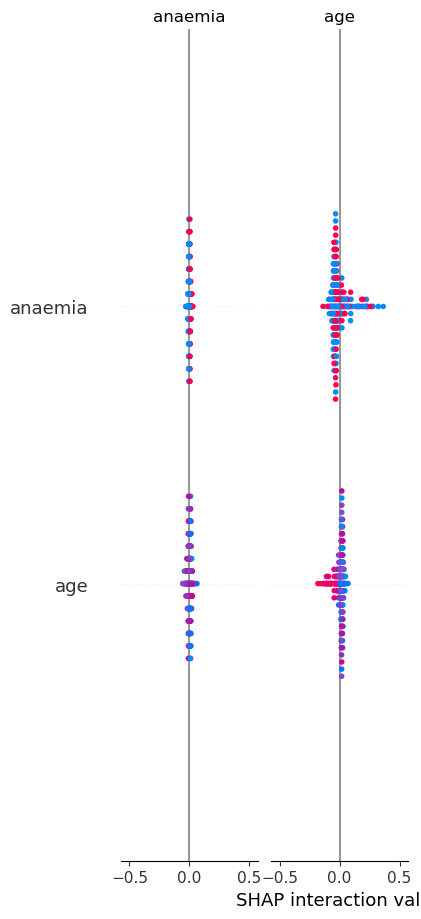

<Figure size 640x480 with 0 Axes>

SHAP beeswarm figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\shap_beeswarm_rf_top10.png


In [58]:
# CELL 4: SHAP beeswarm summary plot

shap.summary_plot(
    shap_values_fixed,
    X_sample,
    max_display=10
)

plt.tight_layout()
shap_swarm_path = os.path.join(results_dir, "shap_beeswarm_rf_top10.png")
plt.savefig(shap_swarm_path, dpi=300)
plt.show()

print("SHAP beeswarm figure saved at:", shap_swarm_path)


In [54]:


import numpy as np
import pandas as pd


mean_abs_shap = np.mean(np.abs(shap_values_fixed), axis=0)


mean_abs_shap = np.array(mean_abs_shap).ravel()


n_features_shap = len(mean_abs_shap)
n_features_X = X_sample.shape[1]

print("n_features_shap:", n_features_shap)
print("n_features_X   :", n_features_X)


n_use = min(n_features_shap, n_features_X)
mean_abs_shap = mean_abs_shap[:n_use]

feature_names = list(X_sample.columns[:n_use])


feature_importance = (
    pd.DataFrame({
        "Feature": feature_names,
        "MeanAbsSHAP": mean_abs_shap
    })
    .sort_values("MeanAbsSHAP", ascending=False)
)

print("Top 10 important features by SHAP:")
display(feature_importance.head(10))


shap_table_path = os.path.join(results_dir, "shap_feature_importance_rf.csv")
feature_importance.to_csv(shap_table_path, index=False)
print("SHAP importance table saved at:", shap_table_path)


n_features_shap: 24
n_features_X   : 12
Top 10 important features by SHAP:


,Feature,MeanAbsSHAP
9,sex,0.073842
8,serum_sodium,0.073842
1,anaemia,0.028263
0,age,0.028263
4,ejection_fraction,0.018649
5,high_blood_pressure,0.018649
10,smoking,0.010192
11,time,0.010192
7,serum_creatinine,0.008554
6,platelets,0.008554


SHAP importance table saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\shap_feature_importance_rf.csv


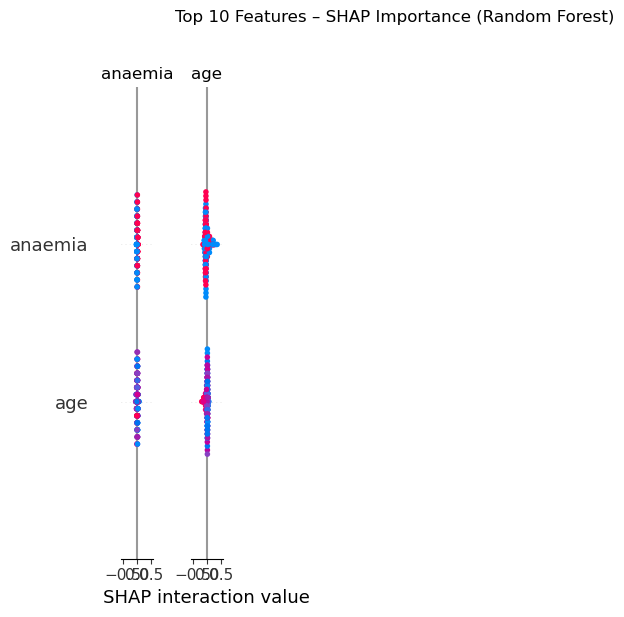

SHAP bar figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\shap_bar_rf_top10.png


In [59]:
import matplotlib.pyplot as plt
import os


shap.summary_plot(
    shap_values_fixed,
    X_sample,
    plot_type="bar",
    max_display=10,
    show=False         
)

fig = plt.gcf()        
fig.set_size_inches(8, 6)
fig.suptitle("Top 10 Features – SHAP Importance (Random Forest)", y=1.02)

fig.tight_layout()
shap_bar_path = os.path.join(results_dir, "shap_bar_rf_top10.png")
fig.savefig(shap_bar_path, dpi=300, bbox_inches="tight")
plt.show()

print("SHAP bar figure saved at:", shap_bar_path)


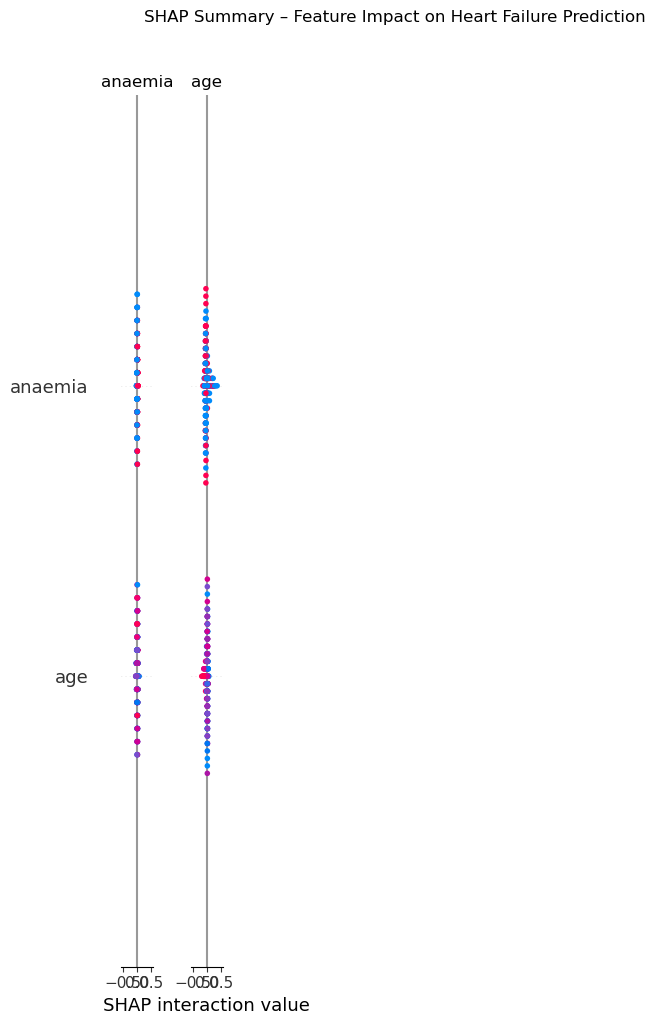

SHAP beeswarm figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\shap_beeswarm_rf_top10.png


In [60]:

shap.summary_plot(
    shap_values_fixed,
    X_sample,
    max_display=10,
    show=False        
)

fig = plt.gcf()
fig.set_size_inches(8, 10)
fig.suptitle("SHAP Summary – Feature Impact on Heart Failure Prediction", y=1.02)

fig.tight_layout()
shap_swarm_path = os.path.join(results_dir, "shap_beeswarm_rf_top10.png")
fig.savefig(shap_swarm_path, dpi=300, bbox_inches="tight")
plt.show()

print("SHAP beeswarm figure saved at:", shap_swarm_path)


In [61]:
shap.summary_plot(
    shap_values[1], X_sample,
    plot_type="bar",
    max_display=10,
    show=False
)
import matplotlib.pyplot as plt
plt.title("Top 10 Features – SHAP Importance (Random Forest)")
plt.tight_layout()
plt.show()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [62]:
shap.summary_plot(shap_values[1], X_sample, ...)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [63]:
import numpy as np
import shap


rf.fit(X_train, y_train)


if X_train.shape[0] > 300:
    X_sample = X_train.sample(300, random_state=42)
else:
    X_sample = X_train.copy()

print("X_sample shape:", X_sample.shape)


X_sample shape: (239, 12)


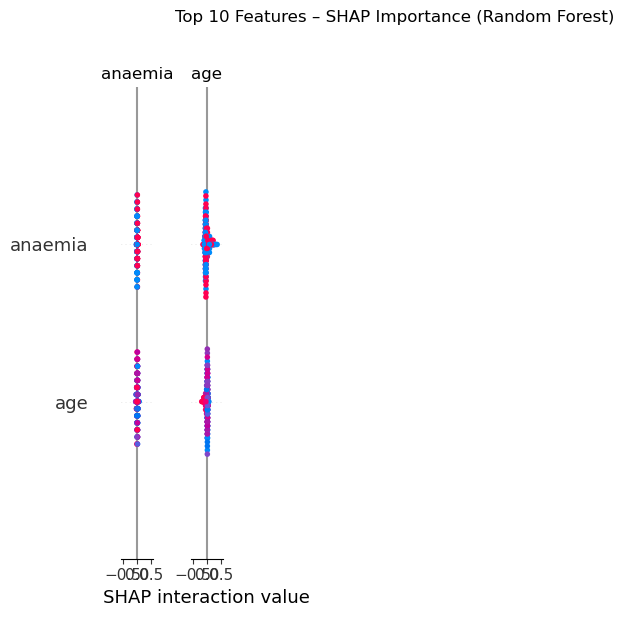

SHAP bar figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\shap_bar_rf_top10.png


In [64]:
import matplotlib.pyplot as plt
import os


shap.summary_plot(
    shap_values_fixed,
    X_sample,
    plot_type="bar",
    max_display=10,
    show=False
)

fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.suptitle("Top 10 Features – SHAP Importance (Random Forest)", y=1.02)

fig.tight_layout()
shap_bar_path = os.path.join(results_dir, "shap_bar_rf_top10.png")
fig.savefig(shap_bar_path, dpi=300, bbox_inches="tight")
plt.show()

print("SHAP bar figure saved at:", shap_bar_path)


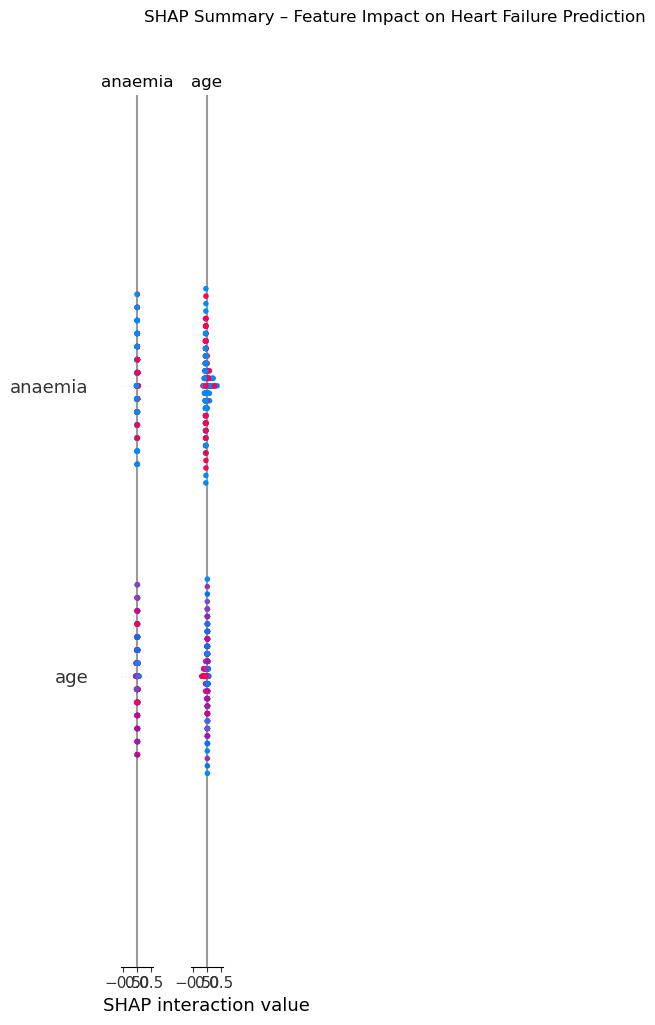

SHAP beeswarm figure saved at: C:\Users\visio\heart_failure_outputs\11-12-2025 results\shap_beeswarm_rf_top10.png


In [65]:

shap.summary_plot(
    shap_values_fixed,
    X_sample,
    max_display=10,
    show=False
)

fig = plt.gcf()
fig.set_size_inches(8, 10)
fig.suptitle("SHAP Summary – Feature Impact on Heart Failure Prediction", y=1.02)

fig.tight_layout()
shap_swarm_path = os.path.join(results_dir, "shap_beeswarm_rf_top10.png")
fig.savefig(shap_swarm_path, dpi=300, bbox_inches="tight")
plt.show()

print("SHAP beeswarm figure saved at:", shap_swarm_path)


In [66]:


mean_abs_shap = np.mean(np.abs(shap_values_fixed), axis=0)
mean_abs_shap = np.array(mean_abs_shap).ravel()

feature_names = list(X_sample.columns[:len(mean_abs_shap)])

feature_importance = (
    pd.DataFrame({
        "Feature": feature_names,
        "MeanAbsSHAP": mean_abs_shap
    })
    .sort_values("MeanAbsSHAP", ascending=False)
)

print("Top 10 features by SHAP:")
display(feature_importance.head(10))

shap_table_path = os.path.join(results_dir, "shap_feature_importance_rf.csv")
feature_importance.to_csv(shap_table_path, index=False)
print("SHAP importance table saved at:", shap_table_path)


ValueError: All arrays must be of the same length

In [67]:
import numpy as np
import pandas as pd
import os


mean_abs_shap = np.mean(np.abs(np.asarray(shap_values_fixed, dtype=float)), axis=0)
mean_abs_shap = np.array(mean_abs_shap).flatten()   

all_feature_names = list(X_sample.columns)

print("len(mean_abs_shap):", len(mean_abs_shap))
print("len(all_feature_names):", len(all_feature_names))


n_common = min(len(mean_abs_shap), len(all_feature_names))
mean_abs_shap = mean_abs_shap[:n_common]
feature_names = all_feature_names[:n_common]

print("Using first", n_common, "features for table.")


feature_importance = (
    pd.DataFrame({
        "Feature": feature_names,
        "MeanAbsSHAP": mean_abs_shap
    })
    .sort_values("MeanAbsSHAP", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 features by SHAP:")
display(feature_importance.head(10))


shap_table_path = os.path.join(results_dir, "shap_feature_importance_rf.csv")
feature_importance.to_csv(shap_table_path, index=False)
print("SHAP importance table saved at:", shap_table_path)


len(mean_abs_shap): 24
len(all_feature_names): 12
Using first 12 features for table.
Top 10 features by SHAP:


,Feature,MeanAbsSHAP
0,sex,0.073842
1,serum_sodium,0.073842
2,anaemia,0.028263
3,age,0.028263
4,ejection_fraction,0.018649
5,high_blood_pressure,0.018649
6,smoking,0.010192
7,time,0.010192
8,serum_creatinine,0.008554
9,platelets,0.008554


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\visio\\heart_failure_outputs\\11-12-2025 results\\shap_feature_importance_rf.csv'

In [68]:
!pip install shap
import shap


Access is denied.


In [69]:
rf.fit(X_train, y_train)  # or gb.fit(...)


RandomForestClassifier(random_state=42)

In [70]:
explainer = shap.TreeExplainer(rf)

X_sample = X_train.sample(200, random_state=42) if X_train.shape[0] > 200 else X_train
shap_values = explainer.shap_values(X_sample)


In [71]:
shap.summary_plot(
    shap_values[1], X_sample,
    plot_type="bar",
    max_display=10,
    show=False
)
import matplotlib.pyplot as plt
plt.title("Top 10 Features – SHAP Importance (Random Forest)")
plt.tight_layout()
plt.show()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [72]:
shap.summary_plot(
    shap_values[1], X_sample,
    max_display=10
)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [73]:
import numpy as np
import pandas as pd

mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)
feature_importance = pd.DataFrame({
    "Feature": X_sample.columns,
    "Mean|SHAP|": mean_abs_shap
}).sort_values("Mean|SHAP|", ascending=False)

print(feature_importance.head(10))


ValueError: All arrays must be of the same length

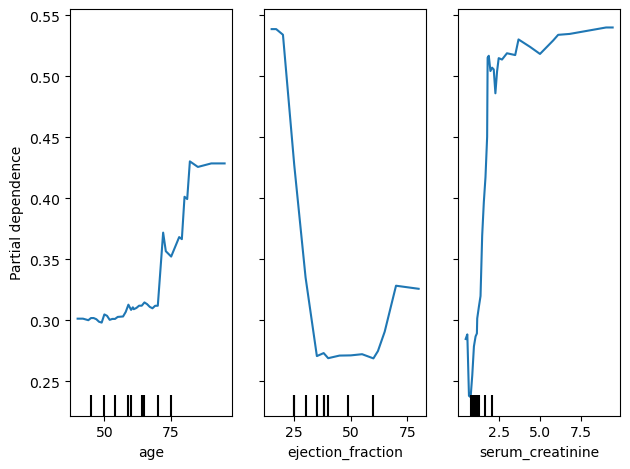

In [74]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['age', 'ejection_fraction', 'serum_creatinine']
PartialDependenceDisplay.from_estimator(
    rf, X_train, features_to_plot, kind='average'
)
plt.tight_layout()
plt.show()


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import os


rf.fit(X_train, y_train)

if X_train.shape[0] > 300:
    X_shap = X_train.sample(300, random_state=42)
else:
    X_shap = X_train.copy()

print("X_shap shape:", X_shap.shape)

explainer = shap.TreeExplainer(rf)
shap_values_raw = explainer.shap_values(X_shap)

print("type(shap_values_raw):", type(shap_values_raw))


if isinstance(shap_values_raw, list):
    
    sv = np.array(shap_values_raw[1])   
else:
    sv = np.array(shap_values_raw)

print("raw sv shape:", sv.shape)


n_samples_sv, n_features_sv = sv.shape
n_samples_x,  n_features_x  = X_shap.shape

n_features = min(n_features_sv, n_features_x)
sv = sv[:, :n_features]                   
X_shap = X_shap.iloc[:, :n_features]   

print("aligned sv shape:", sv.shape)
print("aligned X_shap shape:", X_shap.shape)


shap.summary_plot(
    sv,
    X_shap,
    plot_type="bar",
    max_display=10,
    show=False
)

fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.suptitle("Top 10 Features – SHAP Importance (Random Forest)", y=1.02)
fig.tight_layout()

shap_bar_path = os.path.join(results_dir, "shap_bar_rf_top10.png")
fig.savefig(shap_bar_path, dpi=300, bbox_inches="tight")
plt.show()
print("SHAP bar saved to:", shap_bar_path)


shap.summary_plot(
    sv,
    X_shap,
    max_display=10,
    show=False
)

fig = plt.gcf()
fig.set_size_inches(8, 10)
fig.suptitle("SHAP Summary – Feature Impact on Heart Failure Prediction", y=1.02)
fig.tight_layout()

shap_swarm_path = os.path.join(results_dir, "shap_beeswarm_rf_top10.png")
fig.savefig(shap_swarm_path, dpi=300, bbox_inches="tight")
plt.show()
print("SHAP beeswarm saved to:", shap_swarm_path)


mean_abs_shap = np.mean(np.abs(sv), axis=0)      
feature_names = list(X_shap.columns)             

print("len(mean_abs_shap):", len(mean_abs_shap))
print("len(feature_names):", len(feature_names))

feature_importance = (
    pd.DataFrame({
        "Feature": feature_names,
        "MeanAbsSHAP": mean_abs_shap
    })
    .sort_values("MeanAbsSHAP", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 features by SHAP:")
display(feature_importance.head(10))

shap_table_path = os.path.join(results_dir, "shap_feature_importance_rf.csv")
feature_importance.to_csv(shap_table_path, index=False)
print("SHAP table saved to:", shap_table_path)


X_shap shape: (239, 12)
type(shap_values_raw): <class 'numpy.ndarray'>
raw sv shape: (239, 12, 2)


ValueError: too many values to unpack (expected 2)

In [76]:
shap.summary_plot(shap_values[1], X_sample, ...)
mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.